In [95]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import cv2 as cv
import numpy as np
import os
import glob
import matplotlib.pyplot as plt

# U-Net模块
初始化：
```python
net = UNet(in_channels=4, out_channels=1)
```
输出结果：
```python
sigma_u, sigma_v = net(inputs)
```

In [96]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x
    
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1):
        super(UNet, self).__init__()

        # Down sampling
        self.conv1 = double_conv(in_channels, 64)
        self.conv2 = double_conv(64, 128)
        self.conv3 = double_conv(128, 256)
        self.conv4 = double_conv(256, 512)
        
        self.conv1_1 = double_conv(in_channels, 64)
        self.conv2_1 = double_conv(64, 128)
        self.conv3_1 = double_conv(128, 256)
        self.conv4_1 = double_conv(256, 512)
        
        self.conv1_2 = double_conv(in_channels, 64)
        self.conv2_2 = double_conv(64, 128)
        self.conv3_2 = double_conv(128, 256)
        self.conv4_2 = double_conv(256, 512)

        # Up sampling
        # self.up_conv1 = up_conv(512, 256)
        # self.conv5 = double_conv(512, 256)
        # self.up_conv2 = up_conv(256, 128)
        # self.conv6 = double_conv(256, 128)
        # self.up_conv3 = up_conv(128, 64)
        # self.conv7 = double_conv(128, 64)
        
        self.up_conv1_1 = up_conv(512, 256)
        self.conv5_1 = double_conv(512, 256)
        self.up_conv2_1 = up_conv(256, 128)
        self.conv6_1 = double_conv(256, 128)
        self.up_conv3_1 = up_conv(128, 64)
        self.conv7_1 = double_conv(128, 64)
        
        self.up_conv1_2 = up_conv(512, 256)
        self.conv5_2 = double_conv(512, 256)
        self.up_conv2_2 = up_conv(256, 128)
        self.conv6_2 = double_conv(256, 128)
        self.up_conv3_2 = up_conv(128, 64)
        self.conv7_2 = double_conv(128, 64)

        self.final_conv_1 = nn.Conv2d(64, out_channels, kernel_size=1)
        self.final_conv_2 = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Down sampling
        x1 = self.conv1(x)
        x2 = self.conv2(F.max_pool2d(x1, 2))
        x3 = self.conv3(F.max_pool2d(x2, 2))
        x4 = self.conv4(F.max_pool2d(x3, 2))

        # Up sampling
        # x = self.up_conv1(x4)
        # x = torch.cat([x3, x], dim=1)
        # x = self.conv5(x)
        # x = self.up_conv2(x)
        # x = torch.cat([x2, x], dim=1)
        # x = self.conv6(x)
        # x = self.up_conv3(x)
        # x = torch.cat([x1, x], dim=1)
        # x = self.conv7(x)
        
        sigma_u = self.up_conv1_1(x4)
        sigma_u = torch.cat([x3, sigma_u], dim=1)
        sigma_u = self.conv5_1(sigma_u)
        sigma_u = self.up_conv2_1(sigma_u)
        sigma_u = torch.cat([x2, sigma_u], dim=1)
        sigma_u = self.conv6_1(sigma_u)
        sigma_u = self.up_conv3_1(sigma_u)
        sigma_u = torch.cat([x1, sigma_u], dim=1)
        sigma_u = self.conv7_1(sigma_u)
        
        sigma_v = self.up_conv1_2(x4)
        sigma_v = torch.cat([x3, sigma_v], dim=1)
        sigma_v = self.conv5_2(sigma_v)
        sigma_v = self.up_conv2_2(sigma_v)
        sigma_v = torch.cat([x2, sigma_v], dim=1)
        sigma_v = self.conv6_2(sigma_v)
        sigma_v = self.up_conv3_2(sigma_v)
        sigma_v = torch.cat([x1, sigma_v], dim=1)
        sigma_v = self.conv7_2(sigma_v)

        sigma_u = self.final_conv_1(sigma_u)
        sigma_v = self.final_conv_2(sigma_v)
        
        return sigma_u, sigma_v


# Loss Function
## 输入 
网络输出的sigma（N*1*W*H）  
计算得到的光流场v（N*1*W*H）  
光流场真值v_t（N*1*W*H）   
设备device  
## 输出
偏差值loss

In [97]:
def custom_loss(sigma, v, v_t, device):
    
    v = v.unsqueeze(1)
    v_t = v_t.unsqueeze(1)
    
    eps = torch.full((len(sigma), 1, 256, 256), 1e-10).to(device)
    sigma2 = torch.square(sigma) + eps
    # print(f"sigam2.shape: {sigma2.shape}, eps.shape: {eps.shape}, v.shape: {v.shape}, v_t.shape: {v_t.shape}")
    loss = torch.log(sigma2) + torch.square(v_t - v) / sigma2

    return loss.mean()


In [98]:
class MyDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.data_files = glob.glob(os.path.join(self.data_path, '*.npy'))
        # self.data_files = sorted(self.data_path)
        randomidx = np.random.permutation(len(self.data_files))
        self.data_files = [self.data_files[i] for i in randomidx]
        # print(self.data_files)
        
    def __len__(self):
        return len(self.data_files)

    """
    `__getitem__` 方法会在每次加载一个数据时被调用，
    它会从指定路径中读取 `.npy` 文件，并将其转换为一个 PyTorch 张量。
    然后，使用 PyTorch 提供的 `DataLoader` 类，将数据划分为批次进行训练。
    """
    def __getitem__(self, index):
        # Load data from file
        # data = np.load(os.path.join(self.data_path, self.data_files[index]))
        data = np.load(self.data_files[index])
        # data = data[0:4]
        # Convert to tensor
        data = torch.from_numpy(data).float()
        return data
    
def load_data(data_path, batch_size):
    # Create data loader
    dataset = MyDataset(data_path)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return data_loader

In [99]:
def remap(inputs, device):
    inputs = inputs.cpu().numpy()
    N = inputs.shape[0]
    inputs_split_list = np.split(inputs, N, axis=0)
    inputs_split_list = [np.squeeze(i, axis=0) for i in inputs_split_list]
    # print(inputs_split_list[0].shape)
    for i in range(N):
        img0 = inputs_split_list[i][0]
        img1 = inputs_split_list[i][1]
        u = inputs_split_list[i][2]
        v = inputs_split_list[i][3]

        x, y = np.meshgrid(np.arange(img1.shape[1]), np.arange(img1.shape[0]))
        x = np.float32(x)
        y = np.float32(y)
        img0 = cv.remap(img0, x+u, y+v, interpolation = 4)
        
    inputs_new = np.stack(inputs_split_list, axis = 0)
    inputs_new = torch.from_numpy(inputs_new)

    return inputs_new.to(device)

In [100]:
def train(model, optimizer, data_loader, num_epochs, device):
    
    model.to(device)
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_metric_u = 0.0
        epoch_metric_v = 0.0
        num_batches = 0

        for batch in data_loader:
            batch = batch.to(device)

            inputs = batch[:, :4, :, :]

            v_u = batch[:, 2, :, :]
            v_v = batch[:, 3, :, :]
            v_t_u = batch[:, 4, :, :]
            v_t_v = batch[:, 5, :, :]
            
            inputs = remap(inputs, device)
            # 将梯度清零
            optimizer.zero_grad()
            # 前向传递
            sigma_u, sigma_v = model(inputs)
            # 计算损失和评估指标
            loss_u = custom_loss(sigma_u, v_u, v_t_u, device)
            loss_v = custom_loss(sigma_v, v_v, v_t_v, device)
            
            metric_u = loss_u.item()
            metric_v = loss_v.item()
            
            loss = loss_u + loss_v
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            # 更新损失和评估指标
            epoch_loss += loss.item()
            epoch_metric_u += metric_u
            epoch_metric_v += metric_v
            num_batches += 1

        # 计算平均损失和评估指标
        avg_loss = epoch_loss / num_batches
        avg_metric_u = epoch_metric_u / num_batches
        avg_metric_v = epoch_metric_v / num_batches
        
        losses.append(avg_loss)
        # 打印训练进度
        print(f"Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.4f}, Metric_u={avg_metric_u:.4f}, Metric_v={avg_metric_v:.4f}")

        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('loss')
        plt.yscale('log')
        plt.title('Training Loss')
        plt.savefig('loss.png')    
        if epoch % 5 == 0:
            save_path = '/home/panding/code/UR/ur-model/model-'+str(epoch)+'.model.pt'
            torch.save(model.state_dict(), save_path)

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.yscale('log')
    plt.title('Training Loss')
    plt.savefig('loss.png')    
    torch.save(model.state_dict(), 'model.pt')

In [101]:
# 加载数据
data_path = '/home/panding/code/UR/piv-data/raft-piv'
batch_size = 2

my_data_loader = load_data(data_path, batch_size)

# 初始化模型、优化器和设备
net = UNet(in_channels=4, out_channels=1)
Adam_optimizer = optim.Adam(net.parameters(), lr=0.005)
my_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练循环
my_num_epochs = 500

Epoch 1/500: Loss=11368.8248, Metric_u=8271.4653, Metric_v=3097.3595
Epoch 2/500: Loss=8636.7886, Metric_u=3070.6952, Metric_v=5566.0934
Epoch 3/500: Loss=2203.6266, Metric_u=2202.0781, Metric_v=1.5485
Epoch 4/500: Loss=1397.2089, Metric_u=1395.6035, Metric_v=1.6054
Epoch 5/500: Loss=1209.1173, Metric_u=1207.5138, Metric_v=1.6035
Epoch 6/500: Loss=1513.3387, Metric_u=1511.5697, Metric_v=1.7690
Epoch 7/500: Loss=1896.3188, Metric_u=1175.5476, Metric_v=720.7712
Epoch 8/500: Loss=616.7800, Metric_u=613.4242, Metric_v=3.3559
Epoch 9/500: Loss=26.7091, Metric_u=3.5308, Metric_v=23.1784
Epoch 10/500: Loss=5.5391, Metric_u=3.5258, Metric_v=2.0134
Epoch 11/500: Loss=5.5389, Metric_u=3.5242, Metric_v=2.0147
Epoch 12/500: Loss=5.5376, Metric_u=3.5230, Metric_v=2.0146
Epoch 13/500: Loss=5.5363, Metric_u=3.5221, Metric_v=2.0141


KeyboardInterrupt: 

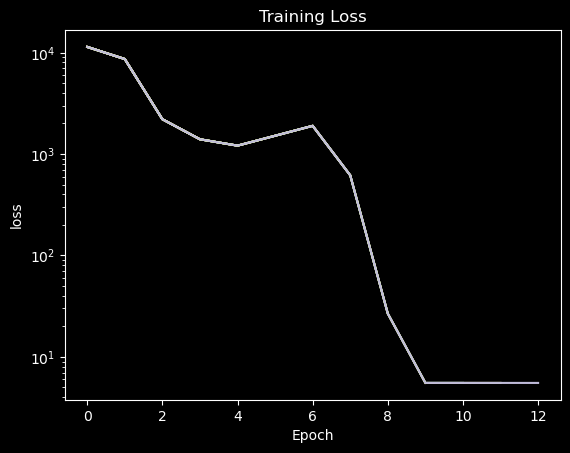

In [102]:
train(model=net, optimizer=Adam_optimizer, data_loader=my_data_loader, num_epochs=my_num_epochs, device=my_device)